In [7]:
import numpy as np
seed = 7
np.random.seed(seed)
import pandas as pd
from keras.layers import Input, Activation, Dense, Convolution2D, MaxPooling2D, Dropout, Flatten, merge
from keras.models import Model

In [8]:
####################
# Global Variables #
####################
nx = 25 # size of image in eta
ny = 25 # size of image in phi
xbins = np.linspace(-1.0,1.0,nx+1)
ybins = np.linspace(-1.0,1.0,ny+1)

In [9]:
input_layer = Input(shape=(nx,ny,1))
layer = Convolution2D(15, (9,9), padding='same')(input_layer)
layer = Activation('tanh')(layer)
layer = MaxPooling2D(pool_size=(2,2))(layer)
layer = Convolution2D(10, (7,7), padding='same')(layer)
layer = Activation('tanh')(layer)
layer = MaxPooling2D(pool_size=(3,3))(layer)
layer = Convolution2D(8, (5,5), padding='same')(layer)
layer = Activation('tanh')(layer)
layer = Convolution2D(6, (5,5), padding='same')(layer)
layer = Activation('tanh')(layer)
layer = MaxPooling2D(pool_size=(2,2))(layer)
layer = Convolution2D(4, (5,5), padding='same')(layer)
layer = Activation('tanh')(layer)

layer = Flatten()(layer)

# additional features input
jet_eta_ak7_input = Input(shape=(1,), name='jet_eta_ak7_input')
layer = merge([layer, jet_eta_ak7_input], mode='concat')
layer = Dense(20, activation='sigmoid')(layer)
layer = Dropout(0.08)(layer)
jet_pt_ak7_input = Input(shape=(1,), name='jet_pt_ak7_input')
layer = merge([layer, jet_pt_ak7_input], mode='concat')
layer = Dense(20, activation='softplus')(layer)
layer = Dropout(0.08)(layer)
output_layer = Dense(1, activation='linear', name='main_output')(layer)
model = Model(inputs=[input_layer,jet_pt_ak7_input,jet_eta_ak7_input], outputs=output_layer)

#model.compile(optimizer='adam', loss='mse', metrics=['accuracy','precision','mse','msle'])
model.compile(optimizer='adam', loss='mse', metrics=['accuracy','mse','msle'])
model.summary()

/Users/rohan/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:20: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/Users/rohan/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:24: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 25, 25, 1)     0                                            
____________________________________________________________________________________________________
conv2d_6 (Conv2D)                (None, 25, 25, 15)    1230        input_2[0][0]                    
____________________________________________________________________________________________________
activation_6 (Activation)        (None, 25, 25, 15)    0           conv2d_6[0][0]                   
____________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)   (None, 12, 12, 15)    0           activation_6[0][0]               
___________________________________________________________________________________________

In [10]:
df_dict_jets = pd.read_pickle('data/df_dict_jets.pkl')
jet_images = np.load('data/jet_images.npy')

In [11]:
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20)
kfold = StratifiedKFold(n_splits=2, shuffle=True,  random_state=seed)
bs=256

In [18]:
history = model.fit([jet_images, df_dict_jets['jet_pt'], df_dict_jets['jet_eta']],  df_dict_jets['jet_jes'],
                    validation_data=([jet_images, df_dict_jets['jet_pt'], df_dict_jets['jet_eta']],  df_dict_jets['jet_jes']),
                    nb_epoch=400, batch_size=bs, verbose=1, callbacks=[early_stopping])

/Users/rohan/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  after removing the cwd from sys.path.


Train on 52992 samples, validate on 52992 samples
Epoch 1/4
52992/52992 [==============================] - 165s - loss: 0.0186 - acc: 0.0000e+00 - mean_squared_error: 0.0186 - mean_squared_logarithmic_error: 0.0049 - val_loss: 0.0010 - val_acc: 0.0000e+00 - val_mean_squared_error: 0.0010 - val_mean_squared_logarithmic_error: 2.5207e-04
Epoch 2/4
52992/52992 [==============================] - 170s - loss: 0.0143 - acc: 0.0000e+00 - mean_squared_error: 0.0143 - mean_squared_logarithmic_error: 0.0037 - val_loss: 0.0011 - val_acc: 0.0000e+00 - val_mean_squared_error: 0.0011 - val_mean_squared_logarithmic_error: 2.6116e-04
Epoch 3/4
52992/52992 [==============================] - 157s - loss: 0.0116 - acc: 0.0000e+00 - mean_squared_error: 0.0116 - mean_squared_logarithmic_error: 0.0030 - val_loss: 0.0013 - val_acc: 0.0000e+00 - val_mean_squared_error: 0.0013 - val_mean_squared_logarithmic_error: 3.1094e-04
Epoch 4/4
52992/52992 [==============================] - 137s - loss: 0.0099 - acc: 0.

In [19]:
model.save('models/DeepJEC.h5')

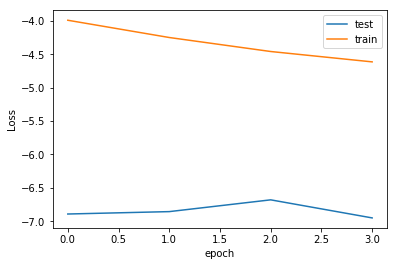

In [20]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

val_loss = np.asarray(history.history['val_loss'])
loss = np.asarray(history.history['loss'])
plt.plot(np.log(val_loss), label='test')
plt.plot(np.log(loss), label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('Loss')

plt.savefig('plots/train_val_loss.pdf')